In [19]:
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import torch
import tqdm
import time
import math
import os
import csv
from collections import OrderedDict

from external_utils import format_time
from utils.data_preprocessing import preprocess_dataset_get_dataset, generate_dataset_from_loader,preprocess_dataset_get_data_loader,get_data_loader
from structure.dlgn_conv_config_structure import DatasetConfig
from conv4_models import get_model_instance, get_model_save_path, get_model_instance_from_dataset, get_img_size
import numpy as np
from utils.generic_utils import Y_True_Loss

from adversarial_attacks_tester import apply_adversarial_attack_on_input,get_model_from_path
from matplotlib import pyplot as plt
from matplotlib import colors
from utils.generic_utils import Y_Logits_Binary_class_Loss

In [20]:
def plot_weights(all_weights):
    fig, axs = plt.subplots(len(all_weights), all_weights[0].shape[0],figsize=(120, 50))
    fig.suptitle('All weights of model plotting as image per row')
    print("Rows:{} Cols:{}".format(len(all_weights),all_weights[0].shape[0]))
    for i in range(len(all_weights)):
        images = []
        for j in range(all_weights[i].shape[0]):
            images.append(axs[i, j].imshow(np.reshape(all_weights[i][j],(28,28))))
            axs[i, j].set_title('Layer:{} Weight of gate:{}'.format(i,j))
            axs[i, j].label_outer()

        # Find the min and max of all colors for use in setting the color scale per row
        vmin = min(image.get_array().min() for image in images)
        vmax = max(image.get_array().max() for image in images)
        norm = colors.Normalize(vmin=vmin, vmax=vmax)
        for im in images:
            im.set_norm(norm)

        fig.colorbar(images[0], ax=axs[i,all_weights[i].shape[0]-1])
    
    fig.tight_layout()

    plt.show()

In [21]:
def plot_weights_correlation(all_weights):
    fig, axs = plt.subplots(len(all_weights), 1,figsize=(50,25))
    fig.suptitle('All weight correlation of model plotting as image per row')
    print("Rows:{}".format(len(all_weights)))
    for i in range(len(all_weights)):
        images = []
        cur_correlation = np.matmul(all_weights[i], all_weights[i].T)
        print("all_weights[i]:{} cur_correlation:{}".format(all_weights[i].shape,cur_correlation.shape))
        images.append(axs[i].imshow(np.reshape(cur_correlation,(all_weights[i].shape[0],all_weights[i].shape[0]))))
        axs[i].set_title('Layer:{} Weight correlations'.format(i))
        axs[i].label_outer()
        fig.colorbar(images[0],ax=axs[i])
    
    fig.tight_layout()

    plt.show()

In [22]:
def plot_model_weights_correlation(all_weights):
    model_weights = []
    print("Rows:{}".format(len(all_weights)))
    for i in range(len(all_weights)):
        model_weights.append(all_weights[i])
    model_weights = np.concatenate(model_weights)
    cur_correlation = np.matmul(model_weights, model_weights.T)
    plt.imshow(cur_correlation, interpolation='nearest')
    plt.title("Full Model WEight correlation")
    plt.colorbar()

    plt.show()

In [23]:
class SaveFeatures():
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        self.features = output
        nw_shape=list(output.size())
        nw_shape.append(output.shape[-1])
        nw = torch.zeros((nw_shape))
        for ind in range(output.shape[-1]):
            nw[:,ind,ind] = output[:,ind]
        # print("nw:{} output:{}".format(nw.shape,output.shape))
        nw = nw.to(device=output.device)
        output = output.cpu()
        del output
        return nw

    def clear_store(self):
        self.features = None

    def close(self):
        self.hook.remove()

In [24]:
class OnlySaveFeatures():
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        self.features = output

    def clear_store(self):
        self.features = None

    def close(self):
        self.hook.remove()

In [25]:
def plot_feature_outs(model,list_of_inp_tuples):
    ghw = 0.1
    gwidth = 0.1
    # set up the figure and axes
    gfig, gaxs = plt.subplots(len(model.get_gate_layers_ordered_dict()),1,figsize=(100, 100))
    out_capturers=[]
    for key,val in model.get_gate_layers_ordered_dict().items():
        out_capturer = OnlySaveFeatures(val)
        out_capturers.append((key,out_capturer))
    with torch.no_grad():
        for sind,(input_name,input_image) in enumerate(list_of_inp_tuples):
            ind_a = 0
            for (key,out_capturer) in out_capturers:
                out_capturer.clear_store()
                model(input_image)
                cur_gate_cont = torch.squeeze(out_capturer.features)
                xs = np.arange(cur_gate_cont.shape[0])
                gaxs[ind_a].bar(xs - (ghw*sind), cur_gate_cont.cpu().numpy(),label=str(input_name),width = gwidth)
                gaxs[ind_a].legend()
                gaxs[ind_a].set_title("Feature out for various adv steps at layer:{}".format(key))
                gaxs[ind_a].set_xlabel("Gate Index")
                gaxs[ind_a].set_xticks(xs)
                gaxs[ind_a].grid(color = 'green', linestyle = '--', linewidth = 0.5,axis = 'y')
                gaxs[ind_a].grid(color = 'red', linestyle = '--', linewidth = 0.5,axis = 'x')
                ind_a += 1
        
        for (_,out_capturer) in out_capturers:
            out_capturer.close()

    plt.show()

In [26]:
def plot_distance_from_HP(model,list_of_inp_tuples):
    ghw = 0.1
    gwidth = 0.1
    # set up the figure and axes
    gfig, gaxs = plt.subplots(len(model.get_gate_layers_ordered_dict()),1,figsize=(100, 100))
    out_capturers=[]
    for key,val in model.get_gate_layers_ordered_dict().items():
        out_capturer = OnlySaveFeatures(val)
        out_capturers.append((key,out_capturer))
    with torch.no_grad():
        for sind,(input_name,input_image) in enumerate(list_of_inp_tuples):
            ind_a = 0
            for (key,out_capturer) in out_capturers:
                out_capturer.clear_store()
                model(input_image)
                cweights = torch.norm(model.get_gate_layers_ordered_dict()[key].weight,2,dim=1)
                cur_gate_cont = torch.abs(torch.squeeze(out_capturer.features) / cweights).cpu().numpy()
                tmp = [(i,v) for i,v in enumerate(cur_gate_cont)]
                print(input_name,key,sorted(tmp,key=lambda x: x[1]))
                xs = np.arange(cur_gate_cont.shape[0])
                gaxs[ind_a].bar(xs - (ghw*sind), cur_gate_cont,label=str(input_name),width = gwidth)
                gaxs[ind_a].legend()
                gaxs[ind_a].set_title("Distance from HP for various adv steps at layer:{}".format(key))
                gaxs[ind_a].set_xlabel("Gate Index")
                gaxs[ind_a].set_xticks(xs)
                gaxs[ind_a].grid(color = 'green', linestyle = '--', linewidth = 0.5,axis = 'y')
                gaxs[ind_a].grid(color = 'red', linestyle = '--', linewidth = 0.5,axis = 'x')
                ind_a += 1
        
        for (_,out_capturer) in out_capturers:
            out_capturer.close()

    plt.show()

In [27]:
def plot_gate_contribution_unit_weight_norm(model,list_of_inp_tuples):
    ghw = 0.1
    gwidth = 0.1
    # set up the figure and axes
    gfig, gaxs = plt.subplots(len(model.get_gate_layers_ordered_dict()),1,figsize=(100, 100))
    for key,val in model.get_gate_layers_ordered_dict().items():
        cweights = torch.norm(val.weight,2,dim=1)
        print(key,cweights)
    with torch.no_grad():
        for sind,(input_name,input_image) in enumerate(list_of_inp_tuples):
            ind_a = 0
            for key,val in model.get_gate_layers_ordered_dict().items():
                out_capturer = SaveFeatures(val)
                out_capturer.clear_store()
                model(input_image)
                # We need to take the logits bcoz the model outputs value after applying sigmoid
                out = torch.squeeze(model.output_logits)
                g = torch.squeeze(nn.Sigmoid()(model.beta * out_capturer.features))
                cur_gate_cont = (1-g) * out
                cweights = torch.norm(val.weight,2,dim=1)
                cur_gate_cont = cur_gate_cont / cweights

                xs = np.arange(cur_gate_cont.shape[0])
                gaxs[ind_a].bar(xs - (ghw*sind), cur_gate_cont.cpu().numpy(),label=str(input_name),width = gwidth)
                gaxs[ind_a].legend()
                gaxs[ind_a].set_title('Gate contribution unit weight norm for various adv steps at layer:{}'.format(key))
                gaxs[ind_a].set_xlabel("Gate Index")
                gaxs[ind_a].set_xticks(xs)
                gaxs[ind_a].grid(color = 'green', linestyle = '--', linewidth = 0.5,axis = 'y')
                gaxs[ind_a].grid(color = 'red', linestyle = '--', linewidth = 0.5,axis = 'x')
                out_capturer.close()
                ind_a += 1

    plt.show()

In [28]:
def plot_gate_contribution(model,list_of_inp_tuples):
    ghw = 0.1
    gwidth = 0.1
    # set up the figure and axes
    gfig, gaxs = plt.subplots(len(model.get_gate_layers_ordered_dict()),1,figsize=(100, 100))
    with torch.no_grad():
        for sind,(input_name,input_image) in enumerate(list_of_inp_tuples):
            ind_a = 0
            for key,val in model.get_gate_layers_ordered_dict().items():
                out_capturer = SaveFeatures(val)
                out_capturer.clear_store()
                model(input_image)
                # We need to take the logits bcoz the model outputs value after applying sigmoid
                out = torch.squeeze(model.output_logits)
                g = torch.squeeze(nn.Sigmoid()(model.beta * out_capturer.features))
                cur_gate_cont = (1-g) * out
                xs = np.arange(cur_gate_cont.shape[0])
                gaxs[ind_a].bar(xs - (ghw*sind), cur_gate_cont.cpu().numpy(),label=str(input_name),width = gwidth)
                gaxs[ind_a].legend()
                gaxs[ind_a].set_title('Gate contribution number for various adv steps at layer:{}'.format(key))
                gaxs[ind_a].set_xlabel("Gate Index")
                gaxs[ind_a].set_xticks(xs)
                gaxs[ind_a].grid(color = 'green', linestyle = '--', linewidth = 0.5,axis = 'y')
                gaxs[ind_a].grid(color = 'red', linestyle = '--', linewidth = 0.5,axis = 'x')
                out_capturer.close()
                ind_a += 1

    plt.show()

In [29]:
# fashion_mnist , mnist, cifar10
dataset = 'mnist'
# conv4_dlgn , plain_pure_conv4_dnn , conv4_dlgn_n16_small , plain_pure_conv4_dnn_n16_small , conv4_deep_gated_net , conv4_deep_gated_net_n16_small
# fc_dnn , fc_dlgn , fc_dgn , dlgn__conv4_dlgn_pad_k_1_st1_bn_wo_bias__, bc_fc_dnn ,  fc_sf_dlgn , madry_mnist_conv4_dnn
model_arch_type = 'bc_fc_sf_dlgn'
batch_size=32
train_transforms = None
custom_dataset_path = None

torch_seed = 2022

list_of_classes_to_train_on = None
list_of_classes_to_train_on = [3,8]

criterion= None
if("bc_" in model_arch_type):
    criterion = Y_Logits_Binary_class_Loss()

adv_target = None
# ACTIVATION_COMPARE , ADV_ATTACK , ACT_COMPARE_RECONST_ORIGINAL , ADV_ATTACK_EVAL_VIA_RECONST , ADV_ATTACK_PER_CLASS , FREQ_BAND_ADV_ATTACK_PER_CLASS
# AFTER_ATT_FREQ_BAND_ADV_ATTACK_PER_CLASS
exp_type = "ADV_ATTACK"
is_adv_attack_on_train = False

if("mnist" in dataset):
    # 40 is a good sweet spot more than that doesn't help much typically
    number_of_adversarial_optimization_steps = 40
    eps = 0.3
    eps_step_size = 0.01
elif("cifar10" in dataset):
    number_of_adversarial_optimization_steps = 10
    eps = 8/255
    eps_step_size = 2/255

# Best attack setting is always  update_on='all' rand_init=True norm=np.inf use_ytrue=True (False attacks slightly less actually contradictory to label leaking since it is multi-step) number_of_restarts=1(more restarts also end up in similar accuracies)
update_on='all'
rand_init=True
norm=np.inf
use_ytrue=True
number_of_restarts = 1
residue_vname = None

is_targetted = adv_target is not None

In [30]:
if(dataset == "mnist"):
    inp_channel = 1
    classes = [str(i) for i in range(0, 10)]
    num_classes = len(classes)
    
    dataset_config = DatasetConfig(
        'mnist', is_normalize_data=True, valid_split_size=0.1, batch_size=batch_size, list_of_classes=list_of_classes_to_train_on, 
        train_transforms=train_transforms,custom_dataset_path=custom_dataset_path)

elif(dataset == "fashion_mnist"):
    inp_channel = 1
    classes = ('T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle-boot')
    num_classes = len(classes)
    
    dataset_config = DatasetConfig(
        'fashion_mnist', is_normalize_data=True, valid_split_size=0.1, batch_size=batch_size, list_of_classes=list_of_classes_to_train_on, 
        train_transforms=train_transforms,custom_dataset_path=custom_dataset_path)
filtered_X_train, filtered_y_train, X_valid, y_valid, filtered_X_test, filtered_y_test = preprocess_dataset_get_dataset(
            dataset_config, model_arch_type, verbose=1, dataset_folder='./Datasets/', is_split_validation=False)

np.max(filtered_X_train) 255.0


In [31]:
num_classes_trained_on = num_classes
dataset_str = dataset

list_of_classes_to_train_on_str = ""
if(list_of_classes_to_train_on is not None):
    for each_class_to_train_on in list_of_classes_to_train_on:
        list_of_classes_to_train_on_str += \
            str(each_class_to_train_on)+"_"
    dataset_str += "_"+str(list_of_classes_to_train_on_str)
    list_of_classes_to_train_on_str = "TR_ON_" + \
        list_of_classes_to_train_on_str[0:-1]
    num_classes_trained_on = len(list_of_classes_to_train_on)
    temp_classes = []
    for ea_c in list_of_classes_to_train_on:
        temp_classes.append(classes[ea_c])
    classes = temp_classes

In [32]:
model_arch_type_str = model_arch_type
if("masked" in model_arch_type):
    mask_percentage = 90
    model_arch_type_str = model_arch_type_str + \
        "_PRC_"+str(mask_percentage)
    net = get_model_instance(
        model_arch_type, inp_channel, mask_percentage=mask_percentage, seed=torch_seed, num_classes=num_classes_trained_on)
elif("fc" in model_arch_type):
    fc_width = 16
    fc_depth = 4
    nodes_in_each_layer_list = [fc_width] * fc_depth
    model_arch_type_str = model_arch_type_str + \
        "_W_"+str(fc_width)+"_D_"+str(fc_depth)
    net = get_model_instance_from_dataset(dataset,
                                            model_arch_type, seed=torch_seed, num_classes=num_classes_trained_on, nodes_in_each_layer_list=nodes_in_each_layer_list)
else:
    net = get_model_instance(model_arch_type, inp_channel,
                                seed=torch_seed, num_classes=num_classes_trained_on)

self.gating_network Gating network  
 module_list:Linear(in_features=784, out_features=16, bias=True) 
 Params in module is:12560
Linear(in_features=784, out_features=16, bias=True) 
 Params in module is:12560
Linear(in_features=784, out_features=16, bias=True) 
 Params in module is:12560
Linear(in_features=784, out_features=16, bias=True) 
 Params in module is:12560

Gating net params: 50240
self.value_network Value network  
 module_list:Linear(in_features=784, out_features=16, bias=True) 
 Params in module is:12560
Linear(in_features=16, out_features=16, bias=True) 
 Params in module is:272
Linear(in_features=16, out_features=16, bias=True) 
 Params in module is:272
Linear(in_features=16, out_features=16, bias=True) 
 Params in module is:272

Value net params: 13393


In [33]:
model_arch_type_str = model_arch_type
if("masked" in model_arch_type):
    mask_percentage = 90
    model_arch_type_str = model_arch_type_str + \
        "_PRC_"+str(mask_percentage)
    copy_net = get_model_instance(
        model_arch_type, inp_channel, mask_percentage=mask_percentage, seed=torch_seed, num_classes=num_classes_trained_on)
elif("fc" in model_arch_type):
    fc_width = 16
    fc_depth = 4
    nodes_in_each_layer_list = [fc_width] * fc_depth
    model_arch_type_str = model_arch_type_str + \
        "_W_"+str(fc_width)+"_D_"+str(fc_depth)
    copy_net = get_model_instance_from_dataset(dataset,
                                            model_arch_type, seed=torch_seed, num_classes=num_classes_trained_on, nodes_in_each_layer_list=nodes_in_each_layer_list)
else:
    copy_net = get_model_instance(model_arch_type, inp_channel,
                                seed=torch_seed, num_classes=num_classes_trained_on)

self.gating_network Gating network  
 module_list:Linear(in_features=784, out_features=16, bias=True) 
 Params in module is:12560
Linear(in_features=784, out_features=16, bias=True) 
 Params in module is:12560
Linear(in_features=784, out_features=16, bias=True) 
 Params in module is:12560
Linear(in_features=784, out_features=16, bias=True) 
 Params in module is:12560

Gating net params: 50240
self.value_network Value network  
 module_list:Linear(in_features=784, out_features=16, bias=True) 
 Params in module is:12560
Linear(in_features=16, out_features=16, bias=True) 
 Params in module is:272
Linear(in_features=16, out_features=16, bias=True) 
 Params in module is:272
Linear(in_features=16, out_features=16, bias=True) 
 Params in module is:272

Value net params: 13393


In [34]:
direct_model_path = "root/model/save/mnist/CLEAN_TRAINING/TR_ON_3_8/ST_2022/bc_fc_sf_dlgn_W_16_D_4_dir.pt"
# direct_model_path = "root/model/save/mnist/adversarial_training/TR_ON_3_8/MT_bc_fc_sf_dlgn_W_16_D_4_ET_ADV_TRAINING/ST_2022/fast_adv_attack_type_FGSM/adv_type_PGD/EPS_0.3/OPT_Adam (Parameter Group 0    amsgrad: False    betas: (0.9, 0.999)    eps: 1e-08    lr: 0.0001    weight_decay: 0)/batch_size_64/eps_stp_size_0.01/adv_steps_40/update_on_all/R_init_True/norm_inf/use_ytrue_True/adv_model_dir_epoch_35.pt"
net = get_model_from_path(dataset, model_arch_type, direct_model_path,custom_model=net)

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = net.to(device)

In [36]:
direct_model_path = "root/model/save/mnist/adversarial_training/TR_ON_3_8/MT_bc_fc_sf_dlgn_W_16_D_4_ET_ADV_TRAINING/ST_2022/fast_adv_attack_type_FGSM/adv_type_PGD/EPS_0.3/OPT_Adam (Parameter Group 0    amsgrad: False    betas: (0.9, 0.999)    eps: 1e-08    lr: 0.0001    weight_decay: 0)/batch_size_64/eps_stp_size_0.01/adv_steps_40/update_on_all/R_init_True/norm_inf/use_ytrue_True/out_lossfn_BCEWithLogitsLoss()/inner_lossfn_Y_Logits_Binary_class_Loss()/adv_model_dir_epoch_35.pt"
copy_net = get_model_from_path(dataset, model_arch_type, direct_model_path,custom_model=copy_net)
copy_net = copy_net.to(device)

In [37]:
seed_gen = torch.Generator()
seed_gen.manual_seed(2022)

In [38]:
# with torch.no_grad():
#     new_state_dict = dict()
#     for name, param in net.state_dict().items():
#         rperm = torch.randperm(np.prod(param.shape),generator=seed_gen)
#         random_mask = torch.reshape(torch.cat([torch.ones(np.prod(param.shape)//3),-torch.ones(np.prod(param.shape) - (np.prod(param.shape)//3))],dim=0)[rperm],param.size()).to(device)
#         print(random_mask)
#         new_state_dict[name] = param + param * 0.05 * random_mask
#     copy_net.load_state_dict(new_state_dict)

In [39]:
# with torch.no_grad():
#     for name, param in net.named_parameters():
#         print(name,param.size(),param)

In [40]:
# with torch.no_grad():
#     for name, param in copy_net.named_parameters():
#         print(name,param.size(),param)

In [41]:
all_weights = [m.weight.detach().cpu().numpy() for m in net.gating_network.list_of_modules]
print([p.shape for p in all_weights])

[(16, 784), (16, 784), (16, 784), (16, 784)]


In [42]:
# plot_weights_correlation(all_weights)

In [43]:
plot_weights(all_weights)

Rows:4 Cols:16


Rows:4


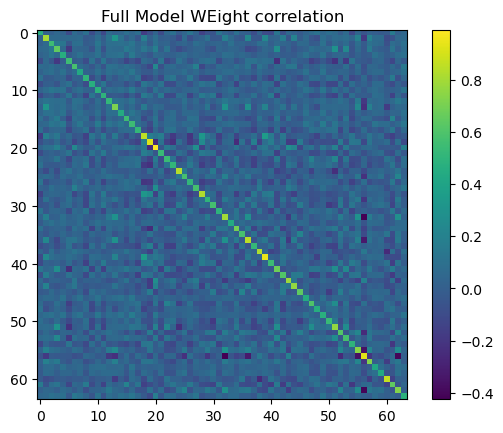

In [44]:
plot_model_weights_correlation(all_weights)

In [45]:
ind = 106
input_data,labels = torch.from_numpy(filtered_X_test[ind])[None,:].to(device),torch.from_numpy(np.array([filtered_y_test[ind]])).to(device)
print("labels ",classes[int(labels[0])])
org_net_out = net(input_data)
if(len(org_net_out.size())==1):
    org_net_out = torch.sigmoid(org_net_out.data).round()
else:
    _, org_net_out = torch.max(org_net_out.data, 1)
print("orig predicted ",classes[int(org_net_out[0])])

labels  3
orig predicted  3


In [46]:
# # FEATURE_FLIP , PGD , FGSM
# adv_attack_type = "FGSM"
# tfgsm_adv_x = apply_adversarial_attack_on_input(input_data, copy_net, eps, adv_attack_type, number_of_adversarial_optimization_steps, eps_step_size, labels, is_targetted,update_on,rand_init,norm,use_ytrue,criterion=criterion)
# adv_net_out = copy_net(tfgsm_adv_x,verbose=4)
# if(len(adv_net_out.size())==1):
#     adv_net_out = torch.sigmoid(adv_net_out.data).round()
# else:
#     _, adv_net_out = torch.max(adv_net_out.data, 1)
# print("labels ",classes[int(labels[0])])
# print("orig predicted ",classes[int(org_net_out[0])])
# print("adv predicted;{} adv_net_out[0]:{} ".format(classes[int(adv_net_out[0])],adv_net_out[0]))
# pert = tfgsm_adv_x-input_data
# plt.imshow(input_data[0].detach().cpu().numpy(), interpolation='nearest')
# plt.title("Original image")
# plt.colorbar()
# plt.show()
# plt.imshow(pert[0].detach().cpu().numpy(), interpolation='nearest')
# plt.title("Perturbation "+adv_attack_type)
# plt.colorbar()
# plt.show()
# plt.imshow(tfgsm_adv_x[0].detach().cpu().numpy(), interpolation='nearest')
# plt.title("Adversarial image"+adv_attack_type)
# plt.colorbar()
# plt.show()

prev_out-----:tensor([[-24.4795,  42.1351,  41.2595,  38.2116,  52.6347,  23.6278,  26.2458,
         -32.6747, -15.7674,  18.1170,  35.6819,  15.1436, -31.2833,  28.7972,
         -13.5395, -24.3575]], device='cuda:0', grad_fn=<AddmmBackward0>) indx:0
prev_out:tensor([[-15.8301,  41.8421,  41.2135,  28.4494,  52.6274,  21.8351,  25.3364,
         -32.6659,  -2.9213,  17.9387,  35.6734,  14.7167, -31.1103,  27.9803,
         -13.5264,  -8.4258]], device='cuda:0', grad_fn=<MulBackward0>) indx:0
prev_out-----:tensor([[ 23.8866,  41.6698, -56.8825,  10.5290, -28.2776, -65.7733, -14.6422,
         -21.0874, -44.0375,  48.6079,  26.8959,  -0.5035,  52.0698,  27.6505,
          37.5530, -45.6558]], device='cuda:0', grad_fn=<AddmmBackward0>) indx:1
prev_out:tensor([[ 23.8858,  26.2674, -51.9631,   4.2374, -24.2664, -65.4883,  -6.2986,
         -14.9560, -43.8728,  48.3513,  20.0057,  -0.4967,  43.3706,  26.1507,
          37.5145,  -4.7053]], device='cuda:0', grad_fn=<MulBackward0>) indx:1
pr

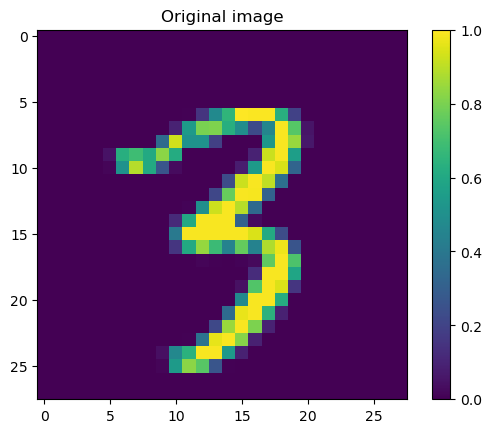

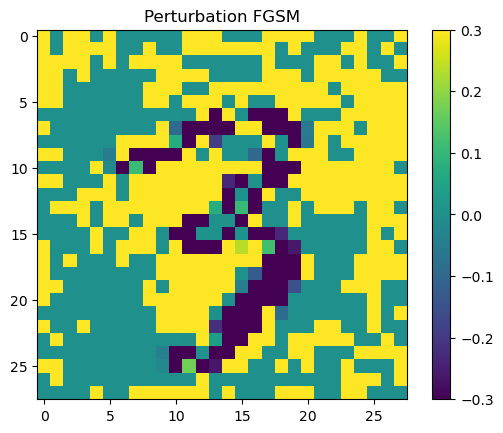

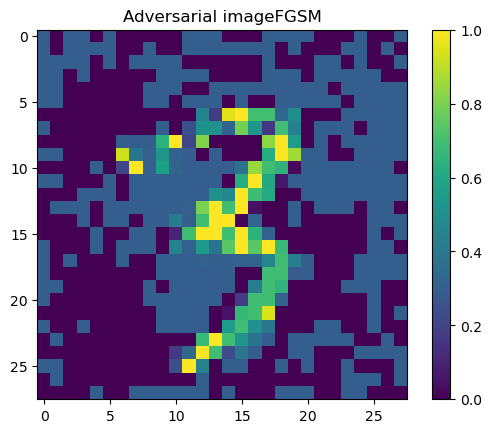

In [47]:
from adversarial_attacks_tester import apply_adversarial_attack_on_input,get_model_from_path
# FEATURE_FLIP , PGD , FGSM
adv_attack_type = "FGSM"
fgsm_adv_x = apply_adversarial_attack_on_input(input_data, net, eps, adv_attack_type, number_of_adversarial_optimization_steps, eps_step_size, labels, is_targetted,update_on,rand_init,norm,use_ytrue,criterion=criterion)
adv_net_out = net(fgsm_adv_x,verbose=4)
if(len(adv_net_out.size())==1):
    adv_net_out = torch.sigmoid(adv_net_out.data).round()
else:
    _, adv_net_out = torch.max(adv_net_out.data, 1)
print("labels ",classes[int(labels[0])])
print("orig predicted ",classes[int(org_net_out[0])])
print("adv predicted ",classes[int(adv_net_out[0])])
pert = fgsm_adv_x-input_data
plt.imshow(input_data[0].detach().cpu().numpy(), interpolation='nearest')
plt.title("Original image")
plt.colorbar()
plt.show()
plt.imshow(pert[0].detach().cpu().numpy(), interpolation='nearest')
plt.title("Perturbation "+adv_attack_type)
plt.colorbar()
plt.show()
plt.imshow(fgsm_adv_x[0].detach().cpu().numpy(), interpolation='nearest')
plt.title("Adversarial image"+adv_attack_type)
plt.colorbar()
plt.show()

In [48]:
dict_3=[]
dict_8=[]
print(["Before Logits","Sign norm dy/dx","Grad norm dy/dx","Sign norm dL/dx","Grad norm dL/dx","Diff b/w dL/dx & dy/dx","Sign norm dL/dy","Grad norm dL/dy","# dL/dy <0","# dL/dy > 0","# dL/dy == 0","Difference between sign dL/dy and dy/x"])
for ind,(each_ex,each_y) in enumerate(zip(filtered_X_test,filtered_y_test)):
    if(each_y==0):
        cdict = dict_3
        cur='3'
    else:
        cdict = dict_8
        cur='8'
    each_ex,each_y = torch.from_numpy(each_ex)[None,:].to(device),torch.from_numpy(np.array([each_y])).to(device)
    each_ex.requires_grad = True
    tout = net(each_ex)
    l = (1 - 2*each_y)*net.output_logits
    l.backward()
    dout_dx = each_ex.grad
    each_ex = each_ex.clone().detach().to(torch.float).requires_grad_(True)
    tmpout = net(each_ex)
    loss = criterion(tmpout,each_y)
    loss.backward()
    dl_dx = each_ex.grad
    tmpout = tmpout.clone().detach().to(torch.float).requires_grad_(True)
    loss = criterion(tmpout,each_y)
    loss.backward()
    dl_dout = tmpout.grad
    lst = [net.output_logits.item(),torch.norm(torch.sign(dout_dx),2).item(),torch.norm(dout_dx,2).item(),torch.norm(torch.sign(dl_dx),2).item(),torch.norm(dl_dx,2).item(),torch.sum(torch.sign(dout_dx)!=torch.sign(dl_dx)).item()
        ,torch.norm(torch.sign(dl_dout),2).item(),torch.norm(dl_dout,2).item(),torch.sum(dl_dout < 0).item(),torch.sum(dl_dout > 0).item(),torch.sum(dl_dout==0).item(),torch.sum(torch.sign(dout_dx)!=torch.sign(dl_dout)).item()]
    cdict.append(lst)
    print(cur,lst)
    

['Before Logits', 'Sign norm dy/dx', 'Grad norm dy/dx', 'Sign norm dL/dx', 'Grad norm dL/dx', 'Diff b/w dL/dx & dy/dx', 'Sign norm dL/dy', 'Grad norm dL/dy', '# dL/dy <0', '# dL/dy > 0', '# dL/dy == 0', 'Difference between sign dL/dy and dy/x']
3 [-7.648647308349609, 28.0, 22.39129066467285, 28.0, 22.39129066467285, 0, 1.0, 1.0, 0, 1, 0, 416]
3 [-24.262678146362305, 28.0, 16.519447326660156, 28.0, 16.519447326660156, 0, 1.0, 1.0, 0, 1, 0, 441]
3 [-22.54361915588379, 28.0, 18.329296112060547, 28.0, 18.329296112060547, 0, 1.0, 1.0, 0, 1, 0, 431]
3 [-14.872030258178711, 28.0, 27.017974853515625, 28.0, 27.017974853515625, 0, 1.0, 1.0, 0, 1, 0, 440]
3 [-19.50151252746582, 28.0, 19.05434226989746, 28.0, 19.05434226989746, 0, 1.0, 1.0, 0, 1, 0, 390]
8 [9.484904289245605, 28.0, 22.621841430664062, 28.0, 22.621841430664062, 0, 1.0, 1.0, 1, 0, 0, 422]
3 [-10.223165512084961, 28.0, 23.12803077697754, 28.0, 23.12803077697754, 0, 1.0, 1.0, 0, 1, 0, 428]
3 [-23.91782569885254, 28.0, 15.9140720367431

In [49]:
len(dict_3),len(dict_8)

(1010, 974)

In [50]:
with open('./root/std/random_model_3s.csv', 'w', newline='') as myfile:
     wr = csv.writer(myfile)
     wr.writerow(["Before Logits","Sign norm dy/dx","Grad norm dy/dx","Sign norm dL/dx","Grad norm dL/dx","Diff b/w dL/dx & dy/dx","Sign norm dL/dy","Grad norm dL/dy","# dL/dy <0","# dL/dy > 0","# dL/dy == 0","Difference between sign dL/dy and dy/x"])
     wr.writerows(dict_3)

In [51]:
dict_3=[]
dict_8=[]
print(["FGSM perturb norm","PGD perturb norm","Perturbation sign difference between FGSM and PGD","PGD_loss","PGD grad sign norm","FGSM loss","FGSM grad sign norm"])
for ind,(each_ex,each_y) in enumerate(zip(filtered_X_test,filtered_y_test)):
    if(each_y==0):
        cdict = dict_3
        cur='3'
    else:
        cdict = dict_8
        cur='8'
    each_ex,each_y = torch.from_numpy(each_ex)[None,:].to(device),torch.from_numpy(np.array([each_y])).to(device)
    pgd_x = apply_adversarial_attack_on_input(each_ex, net, eps, "PGD", number_of_adversarial_optimization_steps, eps_step_size, labels, is_targetted,update_on,rand_init,norm,use_ytrue,criterion=criterion)
    pert_pgd = pgd_x-each_ex
    pgd_x = pgd_x.clone().detach().to(torch.float).requires_grad_(True)
    tout = net(pgd_x)
    pgd_l = (1 - 2*each_y)*tout
    pgd_l.backward()
    pgd_grad = pgd_x.grad

    fgsm_x = apply_adversarial_attack_on_input(each_ex, net, eps, "FGSM", number_of_adversarial_optimization_steps, eps_step_size, labels, is_targetted,update_on,rand_init,norm,use_ytrue,criterion=criterion)
    pert_fgsm = fgsm_x-each_ex
    fgsm_x = fgsm_x.clone().detach().to(torch.float).requires_grad_(True)
    tout = net(fgsm_x)
    fgsm_l = (1 - 2*each_y)*tout
    fgsm_l.backward()
    fgsm_grad = fgsm_x.grad

    lst = [torch.norm(pert_fgsm,2).item(),torch.norm(pert_pgd,2).item(),(torch.sign(pert_fgsm)!=torch.sign(pert_pgd)).sum().item(),pgd_l.item(),torch.norm(torch.sign(pgd_grad),2).item(),fgsm_l.item(),torch.norm(torch.sign(fgsm_grad),2).item()]
    cdict.append(lst)
    print(cur,lst)
    

['FGSM perturb norm', 'PGD perturb norm', 'Perturbation sign difference between FGSM and PGD', 'PGD_loss', 'PGD grad sign norm', 'FGSM loss', 'FGSM grad sign norm']


3 [6.1057915687561035, 5.516756057739258, 176, 44.715389251708984, 28.0, 37.05891799926758, 28.0]
3 [5.972095012664795, 5.511638164520264, 180, 45.91849136352539, 28.0, 31.395030975341797, 28.0]
3 [6.072848320007324, 5.614490032196045, 146, 47.82646560668945, 28.0, 38.48640823364258, 28.0]
3 [5.875038146972656, 5.312756538391113, 216, 45.664554595947266, 28.0, 34.24637222290039, 28.0]
3 [6.2660017013549805, 5.560597896575928, 214, 40.746402740478516, 28.0, 23.747230529785156, 28.0]
8 [6.001470565795898, 5.4553422927856445, 195, -48.05692672729492, 28.0, -40.82912826538086, 28.0]
3 [5.898775577545166, 5.362694263458252, 223, 46.135372161865234, 28.0, 33.16575622558594, 28.0]
3 [6.165703296661377, 5.620881080627441, 214, 44.653564453125, 28.0, 32.55427932739258, 28.0]
3 [5.950046539306641, 5.583695888519287, 158, 48.6132698059082, 28.0, 39.985294342041016, 28.0]
8 [6.196600914001465, 5.393866539001465, 226, -52.595767974853516, 28.0, -39.82840347290039, 28.0]
3 [6.104325771331787, 5.5381

In [54]:
with open('./root/std/std_model_fgsm_vs_pgd_mnist_3s.csv', 'w', newline='') as myfile:
     wr = csv.writer(myfile)
     wr.writerow(["FGSM perturb norm","PGD perturb norm","Perturbation sign difference between FGSM and PGD","PGD_loss","PGD grad sign norm","FGSM loss","FGSM grad sign norm"])
     wr.writerows(dict_3)

cgrad:tensor([[[ 1., -1.,  1.,  1., -1.,  1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,
          -1., -1., -1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1., -1., -1.,  1.],
         [ 1., -1.,  1.,  1.,  1.,  1., -1.,  1.,  1., -1., -1.,  1.,  1.,  1.,
           1.,  1.,  1.,  1., -1.,  1., -1., -1., -1., -1.,  1., -1.,  1., -1.],
         [ 1.,  1.,  1.,  1., -1.,  1., -1.,  1.,  1.,  1.,  1., -1., -1., -1.,
          -1., -1., -1.,  1., -1., -1., -1.,  1.,  1., -1.,  1., -1., -1., -1.],
         [ 1.,  1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1., -1.,
          -1., -1., -1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1., -1., -1.],
         [-1.,  1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1., -1.,  1.,  1.,
           1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.],
         [ 1.,  1., -1., -1., -1., -1., -1., -1.,  1.,  1., -1.,  1.,  1.,  1.,
           1.,  1., -1., -1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1., -1.],
         [-1., -1., -1., -1.

cgrad:tensor([[[ 1., -1.,  1.,  1., -1.,  1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,
          -1., -1., -1.,  1., -1.,  1.,  1.,  1., -1., -1.,  1., -1., -1.,  1.],
         [ 1., -1.,  1.,  1.,  1.,  1., -1., -1.,  1., -1., -1.,  1., -1., -1.,
           1.,  1.,  1., -1., -1.,  1., -1., -1., -1., -1.,  1., -1.,  1., -1.],
         [ 1.,  1.,  1.,  1., -1.,  1., -1.,  1.,  1.,  1.,  1., -1., -1., -1.,
          -1., -1., -1.,  1., -1., -1., -1.,  1.,  1., -1.,  1., -1., -1., -1.],
         [ 1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1., -1.,
          -1., -1., -1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1., -1., -1.],
         [ 1.,  1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1., -1.,  1.,  1.,
           1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.],
         [ 1.,  1., -1., -1., -1., -1., -1., -1.,  1.,  1., -1.,  1.,  1.,  1.,
          -1.,  1., -1., -1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.

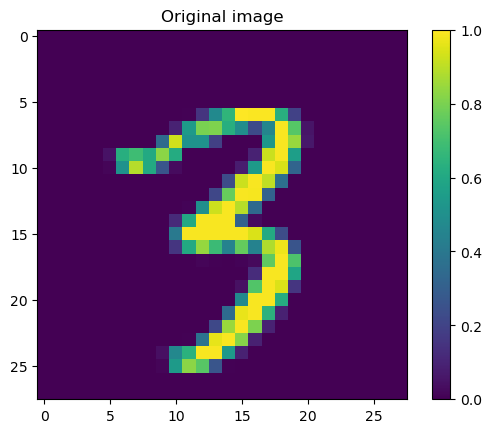

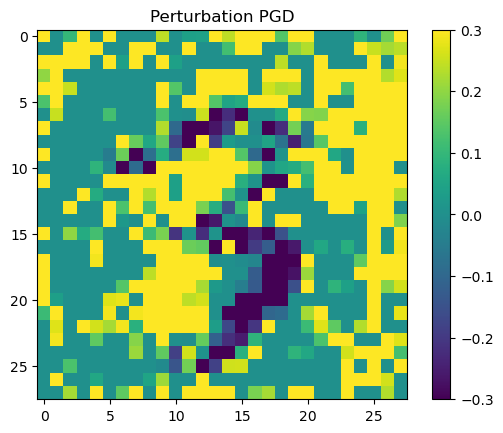

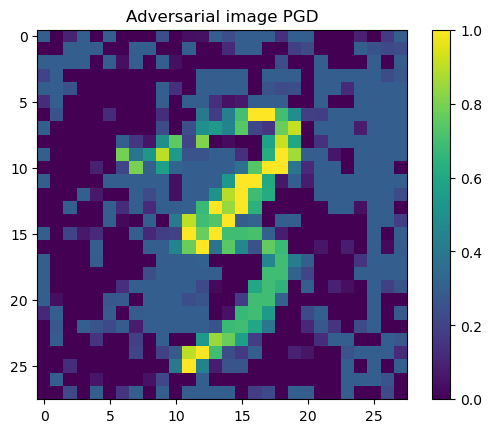

In [32]:
# FEATURE_FLIP , PGD , FGSM
adv_attack_type = "PGD"
pgd_adv_x = apply_adversarial_attack_on_input(input_data, net, eps, adv_attack_type, number_of_adversarial_optimization_steps, eps_step_size, labels, is_targetted,update_on,rand_init,norm,use_ytrue,criterion=criterion)
adv_net_out = net(pgd_adv_x)
if(len(adv_net_out.size())==1):
    adv_net_out = torch.sigmoid(adv_net_out.data).round()
else:
    _, adv_net_out = torch.max(adv_net_out.data, 1)
print("labels ",classes[int(labels[0])])
print("orig predicted ",classes[int(org_net_out[0])])
print("adv predicted ",classes[int(adv_net_out[0])])
pert = pgd_adv_x-input_data
plt.imshow(input_data[0].detach().cpu().numpy(), interpolation='nearest')
plt.title("Original image")
plt.colorbar()
plt.show()
plt.imshow(pert[0].detach().cpu().numpy(), interpolation='nearest')
plt.title("Perturbation "+adv_attack_type)
plt.colorbar()
plt.show()
plt.imshow(pgd_adv_x[0].detach().cpu().numpy(), interpolation='nearest')
plt.title("Adversarial image "+adv_attack_type)
plt.colorbar()
plt.show()

In [32]:
plot_gate_contribution_unit_weight_norm(net,[("Original",input_data),("PGD-Adv",pgd_adv_x),("FGSM-Adv",fgsm_adv_x)])

fc0_g tensor([0.6834, 0.8960, 0.7381, 0.8022, 0.6788, 0.7380, 0.7597, 0.6548, 0.7072,
        0.6844, 0.6941, 0.7042, 0.7155, 0.8423, 0.6672, 0.7443],
       device='cuda:0', grad_fn=<NormBackward1>)
fc1_g tensor([0.7380, 0.7151, 0.9210, 0.9615, 0.9957, 0.7310, 0.7361, 0.7174, 0.9131,
        0.7580, 0.7114, 0.7589, 0.9057, 0.7045, 0.7575, 0.7005],
       device='cuda:0', grad_fn=<NormBackward1>)
fc2_g tensor([0.8928, 0.6656, 0.8338, 0.7620, 0.9203, 0.7184, 0.9040, 0.9712, 0.7382,
        0.8250, 0.7773, 0.8835, 0.8730, 0.8002, 0.6673, 0.7758],
       device='cuda:0', grad_fn=<NormBackward1>)
fc3_g tensor([0.6744, 0.6890, 0.7284, 0.8726, 0.7833, 0.7579, 0.7063, 0.8595, 0.9594,
        0.8488, 0.6447, 0.6554, 0.9320, 0.8039, 0.8489, 0.6960],
       device='cuda:0', grad_fn=<NormBackward1>)
prev_out final:tensor([[[-1.0187],
         [ 8.1604],
         [ 0.0689],
         [ 0.3115],
         [ 0.2216],
         [ 0.5465],
         [ 0.4678],
         [-2.8123],
         [-0.9000],
     

In [33]:
plot_distance_from_HP(net,[("Original",input_data),("PGD-Adv",pgd_adv_x),("FGSM-Adv",fgsm_adv_x)])

prev_out final:tensor([[-22.1582]], device='cuda:0') 
Original fc0_g [(1, 0.12093793), (11, 0.20093334), (13, 0.23983718), (9, 0.46868333), (8, 0.6390378), (5, 0.6403423), (15, 0.7728395), (3, 0.79405385), (0, 1.0275564), (6, 1.1699747), (12, 1.5905132), (2, 1.9868221), (7, 2.4019463), (10, 2.4820385), (14, 2.5023012), (4, 2.7899687)]
prev_out final:tensor([[-22.1582]], device='cuda:0') 
Original fc1_g [(4, 0.34219566), (5, 0.37502462), (2, 0.5468412), (13, 0.5765105), (12, 0.58906007), (8, 0.6960484), (3, 0.71398586), (9, 0.7602513), (15, 0.767968), (1, 0.7795349), (6, 0.8560726), (7, 1.0071278), (11, 1.1416082), (10, 1.3752781), (14, 1.6799515), (0, 3.0222652)]
prev_out final:tensor([[-22.1582]], device='cuda:0') 
Original fc2_g [(5, 0.033055883), (2, 0.09623056), (10, 0.13985029), (12, 0.15914094), (8, 0.16018276), (7, 0.2412375), (0, 0.27883607), (11, 0.32491237), (15, 0.413976), (6, 0.48096898), (4, 0.8805065), (9, 0.9515649), (13, 1.1173941), (3, 1.2427403), (1, 1.7185445), (14, 

In [34]:
plot_feature_outs(net,[("Original",input_data),("PGD-Adv",pgd_adv_x),("FGSM-Adv",fgsm_adv_x)])

prev_out final:tensor([[-22.1582]], device='cuda:0') 
prev_out final:tensor([[-22.1582]], device='cuda:0') 
prev_out final:tensor([[-22.1582]], device='cuda:0') 
prev_out final:tensor([[-22.1582]], device='cuda:0') 
prev_out final:tensor([[19.0641]], device='cuda:0') 
prev_out final:tensor([[19.0641]], device='cuda:0') 
prev_out final:tensor([[19.0641]], device='cuda:0') 
prev_out final:tensor([[19.0641]], device='cuda:0') 
prev_out final:tensor([[36.0580]], device='cuda:0') 
prev_out final:tensor([[36.0580]], device='cuda:0') 
prev_out final:tensor([[36.0580]], device='cuda:0') 
prev_out final:tensor([[36.0580]], device='cuda:0') 


In [35]:
plot_gate_contribution(net,[("Original",input_data),("PGD-Adv",pgd_adv_x),("FGSM-Adv",fgsm_adv_x)])

prev_out final:tensor([[[-1.0187],
         [ 8.1604],
         [ 0.0689],
         [ 0.3115],
         [ 0.2216],
         [ 0.5465],
         [ 0.4678],
         [-2.8123],
         [-0.9000],
         [ 0.6277],
         [ 4.3937],
         [ 2.0815],
         [-0.2678],
         [ 0.8932],
         [-2.1938],
         [-4.7488]]], device='cuda:0') 
prev_out final:tensor([[[  1.4571],
         [ 15.4325],
         [ -0.5506],
         [  5.1480],
         [ -0.3951],
         [-11.9539],
         [ -0.7863],
         [ -4.7276],
         [ -3.9339],
         [  2.3134],
         [  7.8697],
         [ -5.4900],
         [  6.8975],
         [  8.7755],
         [ 10.1959],
         [-22.4718]]], device='cuda:0') 
prev_out final:tensor([[[ 9.4677],
         [-8.4528],
         [-0.6352],
         [-4.2874],
         [25.7991],
         [ 2.7679],
         [-0.5077],
         [-2.5725],
         [-4.4079],
         [-2.0692],
         [ 8.1473],
         [10.7490],
         [-0.4253],